Data Source: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

In this script I clean the dataset of crime reports and add temporal columns. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
pd.options.display.max_columns = 1000

In [207]:
# Reading in the crime data csv file and converting to a dataframe.   
crime_df = pd.read_csv('Crimes_2001_to_present2.csv')

In [208]:
# Examine the first 5 rows of crime_df
crime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,"(41.878064761, -87.743354013)"


Next I am going to go through each column and delete the ones that I don't need.  Here is a description for each column: 
1. ID:   
There is a unique identifier for each report.  
2. Case Number:   
This is the Chicago Police Records Division Number, which is unique to the incident.  I will keep this column for now to see if there are multiple reports for a certain incident. 
3. Date:   
This is the approximate date and time when the incident occurred. 
4. Block:   
This is the block where the incident occurred.  It is in the format of a partially obscured street address. 
5. IUCR:   
This stands for Illinois Uniform Crime Reporting code.  It is linked to the 'Primary Type' and 'Description' columns.  I will keep this for now in case there are any values missing in the 'Primary Type' column.
6. Primary Type:   
This is the primary description of the IUCR code.  This is what I will be trying to predict. 
7. Description:   
This is the secondary description of the IUCR code. 
8. Location Description:   
This is the description of the location where the incident occurred. 
9. Arrest:   
This is a boolean column that indicates whether an arrest was made.  
10. Domestic:   
This is a boolean column that indicates whether the incident was domestic-related. 
11. Beat:   
This is the beat where the incident occurred. A beat is the smallest police geographic area. 
12. District:   
This is the police district where the incident occurred. 
13. Ward:   
This is the ward where the incident occurred. 
14. Community Area:   
This is the community area where the incident occurred. 
15. FBI Code:   
This is the crime classifaction according to the FBI's National Incident-Based Reporting System.  I will keep this column for now in case there are any missing values in the 'Primary Type' column. 
16. X Coordinate:   
This is the x coordinate of the location where the incident occurred.  It is shifted from the actual location, but falls on the same block.  
17. Y Coordinate:   
This is the y coordinate of the location where the incident occurred.  It is shifted from the actual location, but falls on the same block.  
18. Year:   
This is the year the incident occurred. 
19. Updated On :   
This is the Date and time the record was last updated.  
20. Latitude:   
This is the latitude of the location where the incident occurred.  It is shifted from the actual location, but falls on the same block. 
21. Longitude:   
This is the longitude of the location where the incident occurred.  It is shifted from the actual location, but falls on the same block. 
22. Location:   
This is a tuple of both the latitude and longitude.  

The 'Description', 'Arrest', and 'Updated On' columns will be deleted as I won't be able to use them to predict the primary type of crime .  In addition, the 'Location' column will be deleted as it is redundant since I will be using the 'Latitude' and  'Longitude' columns.  I will keep the 'IUCR' and 'FBI Code' columns for now as they may help me fill in any missing values in the 'Primary Type' column. 

In [209]:
# Deleting unneeded columns from crime_df
delete_columns = ['Description', 'Arrest', 'Updated On', 'Location']
for col in delete_columns:
    del crime_df[col]

In [210]:
# Checking the first 5 rows again
crime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,STREET,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,41.891399,-87.744385
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,41.773372,-87.665319
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,2015,41.813861,-87.596643
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,2015,41.800802,-87.622619
4,10000097,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,031A,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,2015,41.878065,-87.743354


In [211]:
# Checking data type for each column and the number of reports
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726718 entries, 0 to 6726717
Data columns (total 18 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Location Description    object
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Latitude                float64
Longitude               float64
dtypes: bool(1), float64(7), int64(3), object(7)
memory usage: 878.9+ MB


In [212]:
# Making sure that each report has a unique ID
len(set(crime_df['ID']))

6726718

The above shows that each row (crime report) has a unique ID.  The 'ID' column will be kept in case I have to perform any merge operations. 

Here I will check for any duplicate records.  First with .drop_duplicates() and then by checking if there are any repeats in the 'Case Number' column. While dropping duplicates, the ID column will be left out. 

In [213]:
# Dropping duplicate reports and checking to see if any were dropped. Excluding 'ID' when dropping duplicates. 
crime_df = crime_df.drop_duplicates(subset = crime_df.columns.difference(['ID']))
len(crime_df)

6726512

The number of crime reports has dropped by 206.  Next I will check the 'Case Number' column. 

In [214]:
# Resetting the index for crime_df before moving on
crime_df = crime_df.reset_index(drop = True)

## Case Number

Here I will check for any more duplicates in reported crimes using the case number.  

In [10]:
# Getting the counts of each case number and checking out the top 10 most frequent case numbers
counts = crime_df['Case Number'].value_counts()
counts[:10]

HJ104730    4
JA432970    4
HY442430    3
JA329470    3
HZ564892    3
JA451059    3
HV217424    3
HY259141    3
HL475827    3
HZ260932    3
Name: Case Number, dtype: int64

In [11]:
# Seeing how many case numbers have duplicates
sum(counts>1)

175

In [12]:
# Examining a few case numbers
mask = crime_df['Case Number'] == 'JA432970'
crime_df[mask]

,ID,Case Number,Date,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
4536179,23579,JA432970,09/15/2017 10:17:00 PM,047XX S FAIRFIELD AVE,0110,HOMICIDE,STREET,False,922,9.0,14.0,58.0,01A,1158834.0,1873224.0,2017,41.807857,-87.692963
4536180,23580,JA432970,09/15/2017 10:18:00 PM,047XX S FAIRFIELD AVE,0110,HOMICIDE,STREET,False,922,9.0,14.0,58.0,01A,1158834.0,1873224.0,2017,41.807857,-87.692963
4536181,23581,JA432970,09/15/2017 10:19:00 PM,047XX S FAIRFIELD AVE,0110,HOMICIDE,STREET,False,922,9.0,14.0,58.0,01A,1158834.0,1873224.0,2017,41.807857,-87.692963
4536182,23582,JA432970,09/15/2017 10:20:00 PM,047XX S FAIRFIELD AVE,0110,HOMICIDE,STREET,False,922,9.0,14.0,58.0,01A,1158834.0,1873224.0,2017,41.807857,-87.692963


In [13]:
mask = crime_df['Case Number'] == 'HJ104730'
crime_df[mask]

,ID,Case Number,Date,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
2357773,1958,HJ104730,01/03/2003 07:45:00 PM,080XX S MICHIGAN AVE,0110,HOMICIDE,HOUSE,False,623,6.0,6.0,44.0,01A,1178549.0,1851687.0,2003,41.748332,-87.621307
2357924,1959,HJ104730,01/03/2003 04:35:00 PM,080XX S MICHIGAN AVE,0110,HOMICIDE,HOUSE,False,623,6.0,6.0,44.0,01A,1178549.0,1851687.0,2003,41.748332,-87.621307
2358038,1960,HJ104730,01/03/2003 05:15:00 PM,080XX S MICHIGAN AVE,0110,HOMICIDE,HOUSE,False,623,6.0,6.0,44.0,01A,1178549.0,1851687.0,2003,41.748332,-87.621307
2358205,1961,HJ104730,01/03/2003 05:40:00 PM,080XX S MICHIGAN AVE,0110,HOMICIDE,HOUSE,False,623,6.0,6.0,44.0,01A,1178549.0,1851687.0,2003,41.748332,-87.621307


In [14]:
mask = crime_df['Case Number'] == 'HY259141'
crime_df[mask]

,ID,Case Number,Date,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
4601657,21860,HY259141,05/13/2015 08:05:00 PM,002XX W 107TH ST,0110,HOMICIDE,AUTO,False,513,5.0,34.0,49.0,01A,1176567.0,1833986.0,2015,41.699803,-87.629101
4601658,21861,HY259141,05/13/2015 11:23:00 PM,002XX W 107TH ST,0110,HOMICIDE,AUTO,False,513,5.0,34.0,49.0,01A,1176567.0,1833986.0,2015,41.699803,-87.629101
4601659,21915,HY259141,06/10/2015 12:01:00 AM,002XX W 107TH ST,0110,HOMICIDE,AUTO,False,513,5.0,34.0,49.0,01A,1176567.0,1833986.0,2015,41.699803,-87.629101


In [15]:
mask = crime_df['Case Number'] == 'HV217424'
crime_df[mask]

,ID,Case Number,Date,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
2374468,20340,HV217424,03/27/2012 10:58:00 PM,063XX S EVANS AVE,0110,HOMICIDE,APARTMENT,False,312,3.0,20.0,42.0,01A,1182310.0,1863074.0,2012,41.779493,-87.607174
2374489,20341,HV217424,03/27/2012 09:58:00 PM,063XX S EVANS AVE,0110,HOMICIDE,APARTMENT,False,312,3.0,20.0,42.0,01A,1182310.0,1863074.0,2012,41.779493,-87.607174
2374516,20342,HV217424,03/27/2012 10:57:00 PM,063XX S EVANS AVE,0110,HOMICIDE,APARTMENT,False,312,3.0,20.0,42.0,01A,1182310.0,1863074.0,2012,41.779493,-87.607174


In [16]:
mask = crime_df['Case Number'] == 'HP424011'
crime_df[mask]

,ID,Case Number,Date,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
4032384,4603,HP424011,06/29/2008 11:17:00 PM,078XX S KINGSTON AVE,0110,HOMICIDE,HALLWAY,False,421,4.0,7.0,43.0,01A,1194548.0,1853550.0,2008,41.753066,-87.562621
4033107,4604,HP424011,06/29/2008 11:18:00 PM,078XX S KINGSTON AVE,0110,HOMICIDE,HALLWAY,False,421,4.0,7.0,43.0,01A,1194548.0,1853550.0,2008,41.753066,-87.562621
4033778,4605,HP424011,06/29/2008 10:11:00 PM,078XX S KINGSTON AVE,0110,HOMICIDE,HALLWAY,False,421,4.0,7.0,43.0,01A,1194548.0,1853550.0,2008,41.753066,-87.562621


After performing crime_df.drop_duplicates(), there were still duplicates in the 'Case Number' column.  I looked up a few of the cases online and saw that in general, duplicate case numbers meant there were multiple victims.  There was one case I saw where the same case number was used for a different day but the same location.  No further information was found online regarding this incident, so it is unknown if this was a case of a case number being mismarked or if the incidents were connected.  I therefore left the  duplicate case numbers in the dataset.  There are 175 case numbers that have been duplicated. 

In [17]:
# 'Case Number' no longer needed so deleting it
del crime_df['Case Number']

## Date

In [18]:
# Checking the 'Date' column for null values
len(crime_df['Date']) - len(crime_df['Date'].dropna())

0

There were no apparent null values in the 'Date' column.  I will now use regular expressions to see if there are any errors in the dates. 

In [19]:
# Setting a pattern for the date and seeing if there are any invalid dates
pattern = r'^\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2} \w+$'

mask = crime_df['Date'].str.contains(pattern)
crime_df['Date'][~mask]

Series([], Name: Date, dtype: object)

No dates were found that didn't follow the pattern.  Now the dates will be converted to DateTime objects.  

In [20]:
# Converting dates to DateTime objects
crime_df['Date_Converted'] = pd.to_datetime(crime_df['Date'], format = '%m/%d/%Y %I:%M:%S %p')

In [21]:
# Checking that the dates converted correctly
crime_df['Date'][:10], crime_df['Date_Converted'][:10]

(0    03/18/2015 07:44:00 PM
 1    03/18/2015 11:00:00 PM
 2    03/18/2015 10:45:00 PM
 3    03/18/2015 10:30:00 PM
 4    03/18/2015 09:00:00 PM
 5    03/18/2015 10:00:00 PM
 6    03/18/2015 11:00:00 PM
 7    03/18/2015 09:35:00 PM
 8    03/18/2015 10:09:00 PM
 9    03/18/2015 09:25:00 PM
 Name: Date, dtype: object, 0   2015-03-18 19:44:00
 1   2015-03-18 23:00:00
 2   2015-03-18 22:45:00
 3   2015-03-18 22:30:00
 4   2015-03-18 21:00:00
 5   2015-03-18 22:00:00
 6   2015-03-18 23:00:00
 7   2015-03-18 21:35:00
 8   2015-03-18 22:09:00
 9   2015-03-18 21:25:00
 Name: Date_Converted, dtype: datetime64[ns])

In [22]:
# Deleting original 'Date' column
del crime_df['Date']

## Year

In [65]:
# Checking the 'Year' column for null values
len(crime_df['Year']) - len(crime_df['Year'].dropna())

0

There were no apparent null values in the 'Year' column and per .info(), the column was properly imported as an integer type. So it appears this column is clean.

## Block

In [25]:
# Checking number of entries in 'Block' column that are missing entries
len(crime_df['Block']) - len(crime_df['Block'].dropna())

0

There were no apparent null values in the 'Block' column.  I will now use a regular expression to check for any other errors. 

In [26]:
# Checking out the first 10 blocks
crime_df['Block'][:10]

0           047XX W OHIO ST
1    066XX S MARSHFIELD AVE
2     044XX S LAKE PARK AVE
3      051XX S MICHIGAN AVE
4          047XX W ADAMS ST
5       049XX S DREXEL BLVD
6         070XX S MORGAN ST
7       042XX S PRAIRIE AVE
8       036XX S WOLCOTT AVE
9       097XX S PRAIRIE AVE
Name: Block, dtype: object

A look at the 'Block' column shows that the entries generally start with 3 numbers and end with letters. The letters seems to be all capitalized, but I will capitalize them with .upper() just in case. 

In [27]:
# Making all letters capitalized in 'Block'
crime_df['Block'] = crime_df['Block'].apply(lambda block: block.upper())

In [28]:
# Checking 'Blocks' with a regular expression
pattern = r'^\d{3}[\d+ A-Z]*$' # Starting with 3 numbers and containing additional numbers and capital letters

mask = crime_df['Block'].str.contains(pattern)
crime_df['Block'][~mask]

698388     005XX N FAIRBANKS CT (PARK N
699289                      XX  UNKNOWN
706169            045XX N PULASKI RD -1
710904                      XX  UNKNOWN
736040               007XX W O'BRIEN ST
822529          006XX S KILPATRICK  ST.
822535            005XX E BROWNING  ST.
1871261         068XX S ST. LAWRENCE AV
1871268                  005XX W 78 ST.
1871272               027XX S STATE ST.
1871273             004XX S PULASKI RD.
1871275                026XX W POLK ST.
1871278                  016XX W 44 ST.
1871358             033XX W FULTON AV `
1899054              002XX W WACKER DR.
1899855          065XX S PROMONTARY DR.
1906695                038XX W POLK ST.
1907470                038XX W POLK ST.
1908215            029XX S DEARBORN ST.
1909016                014XX N WOOD ST.
1912062          066XX S WINCHESTER AV.
1964186           021XX N LAWNDALE AVE`
2015134                016XX W ERIE ST.
2016524                  007XX E 83 ST.
2017316             050XX W LEMOYNE ST.


Two entries that stick out have index 699289 and 710904; the block is unknown in these cases.  

In [30]:
# Examining the entries with the unknown blocks
crime_df.iloc[699289,:], crime_df.iloc[710904,:]

(ID                                  6479762
 Block                           XX  UNKNOWN
 IUCR                                   1822
 Primary Type                      NARCOTICS
 Location Description              APARTMENT
 Domestic                              False
 Beat                                    531
 District                                  5
 Ward                                      9
 Community Area                          NaN
 FBI Code                                 18
 Latitude                                NaN
 Longitude                               NaN
 Date_Converted          2008-08-11 19:50:00
 Name: 699289, dtype: object, ID                                  8220140
 Block                           XX  UNKNOWN
 IUCR                                   0840
 Primary Type                          THEFT
 Location Description                  OTHER
 Domestic                              False
 Beat                                   1821
 District                 

In both cases The latitude and longitude are missing.  I will leave these rows in the dataset for now as I don't know exactly which variables will be used in my model. 

Looking back at the invalid list of blocks, there are single quotes, periods, accents, and a couple entries with ' -1' and ' (PARK N' at the end. To simplify this column, all of these will be stripped. 

In [29]:
# Stripping unneeded characters from 'Block'
crime_df['Block'] = crime_df['Block'].str.replace(' -1|\.|\'|`| \(PARK N', '')

In [32]:
# Checking to see that no more invalid blocks are found
pattern = r'^\d{3}[\d+ A-Z]*$' # Starting with 3 numbers and containing additional numbers and capital letters

mask = crime_df['Block'].str.contains(pattern)
crime_df['Block'][~mask]

699289    XX  UNKNOWN
710904    XX  UNKNOWN
Name: Block, dtype: object

## Primary Type

In [33]:
# Checking the number of missing entries in the 'Primary Type' column
len(crime_df['Primary Type']) - len(crime_df['Primary Type'].dropna())

0

There are no apparent null values in the 'Primary Type' column. 

In [34]:
# Checking out the categories in 'Primary Type'
crime_df['Primary Type'].value_counts()

THEFT                                1412991
BATTERY                              1228590
CRIMINAL DAMAGE                       769380
NARCOTICS                             709729
OTHER OFFENSE                         417205
ASSAULT                               416975
BURGLARY                              387093
MOTOR VEHICLE THEFT                   313488
DECEPTIVE PRACTICE                    260930
ROBBERY                               254886
CRIMINAL TRESPASS                     192878
WEAPONS VIOLATION                      70274
PROSTITUTION                           68257
PUBLIC PEACE VIOLATION                 47671
OFFENSE INVOLVING CHILDREN             45138
CRIM SEXUAL ASSAULT                    26932
SEX OFFENSE                            24971
INTERFERENCE WITH PUBLIC OFFICER       15055
GAMBLING                               14410
LIQUOR LAW VIOLATION                   14036
ARSON                                  11122
HOMICIDE                                9170
KIDNAPPING

Entries in the 'Primary Type' column appear to contain letters that are capitalized and hyphens.  There are 3 categories for non-criminal crimes.  I will strip the extra spaces around the hyphen and get rid of '(SUBJECT SPECIFIED)'. Regular expressions will then be used to ensure there are no other errors.  But first, the column will be capitalized using .upper() just in case. 

In [35]:
# Capitalizing entries in 'Primary Type'
crime_df['Primary Type'] = crime_df['Primary Type'].apply(lambda ptype: ptype.upper())

In [36]:
# Stripping unneeded characters from 'Primary Type'
crime_df['Primary Type'] = crime_df['Primary Type'].str.replace(' - ', '-')
crime_df['Primary Type'] = crime_df['Primary Type'].str.replace(' \(SUBJECT SPECIFIED\)', '')

In [43]:
# Checking out the categories in 'Primary Type' again
crime_df['Primary Type'].value_counts()

THEFT                                1412991
BATTERY                              1228590
CRIMINAL DAMAGE                       769380
NARCOTICS                             709729
OTHER OFFENSE                         417205
ASSAULT                               416975
BURGLARY                              387093
MOTOR VEHICLE THEFT                   313488
DECEPTIVE PRACTICE                    260930
ROBBERY                               254886
CRIMINAL TRESPASS                     192878
WEAPONS VIOLATION                      70274
PROSTITUTION                           68257
PUBLIC PEACE VIOLATION                 47671
OFFENSE INVOLVING CHILDREN             45138
CRIM SEXUAL ASSAULT                    26932
SEX OFFENSE                            24971
INTERFERENCE WITH PUBLIC OFFICER       15055
GAMBLING                               14410
LIQUOR LAW VIOLATION                   14036
ARSON                                  11122
HOMICIDE                                9170
KIDNAPPING

In [44]:
# Checking 'Primary Type' with a regular expression for further errors
pattern = r'^[A-Z -]*$' # Contains capital letters, spaces, and hyphens
mask = crime_df['Primary Type'].str.contains(pattern)
assert sum(~mask) == 0

## Location Description

In [45]:
# Checking the number of missing entries in 'Location Description'
len(crime_df['Location Description']) - len(crime_df['Location Description'].dropna())

3974

There are 3974 missing values in the 'Location Description' column.  I will examine the missing values after cleaning the column. 

In [48]:
# Creating a temporary dataframe with non-null entries
crime_df_notnull = crime_df[pd.notnull(crime_df['Location Description'])]

# Resetting the index for crime_df_notnull before moving on
crime_df_notnull = crime_df_notnull.reset_index(drop = True)

In [49]:
# Checking out the categories in 'Location Description'
crime_df['Location Description'].value_counts()

STREET                            1766020
RESIDENCE                         1139021
APARTMENT                          694604
SIDEWALK                           663846
OTHER                              255629
PARKING LOT/GARAGE(NON.RESID.)     193221
ALLEY                              150509
SCHOOL, PUBLIC, BUILDING           141887
RESIDENCE-GARAGE                   131391
SMALL RETAIL STORE                 118693
RESIDENCE PORCH/HALLWAY            117572
VEHICLE NON-COMMERCIAL             107779
RESTAURANT                         105047
GROCERY FOOD STORE                  87046
DEPARTMENT STORE                    83287
GAS STATION                         71726
RESIDENTIAL YARD (FRONT/BACK)       69127
CHA PARKING LOT/GROUNDS             55423
PARK PROPERTY                       52249
COMMERCIAL / BUSINESS OFFICE        48955
CTA PLATFORM                        36197
CHA APARTMENT                       35956
BAR OR TAVERN                       35793
DRUG STORE                        

It is not apparant if any of these categories can be combined.  But I will clean them up by making sure they are all capitalized and getting rid of extra spaces around hypens and forward slashes. 

In [50]:
# Capitalizing entries in 'Location Description'
crime_df_notnull['Location Description'] = crime_df_notnull['Location Description'].apply(lambda location: location.upper())

In [51]:
# Stripping unneeded characters from 'Location Description'
crime_df_notnull['Location Description'] = crime_df_notnull['Location Description'].str.replace(' - ', '-')
crime_df_notnull['Location Description'] = crime_df_notnull['Location Description'].str.replace(' / ', '/')

In [52]:
# Checking 'Location Description' with a regular expression for errors
pattern = r'^[A-Z -/"().,]*$' # Contains capital letters, spaces, hyphens, quotes, and parentheses
mask = crime_df_notnull['Location Description'].str.contains(pattern)
assert sum(~mask) == 0

In [53]:
# Replacing 'Location Description' values in crime_df with updated values from crime_df_notnull
crime_df.loc[crime_df['ID'].isin(crime_df_notnull['ID']), ['Location Description']] = crime_df_notnull['Location Description'].values

In [59]:
# Checking the 'Location Description' column is ok
crime_df.head()

,ID,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Date_Converted
0,10000092,047XX W OHIO ST,041A,BATTERY,STREET,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,41.891399,-87.744385,2015-03-18 19:44:00
1,10000094,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,41.773372,-87.665319,2015-03-18 23:00:00
2,10000095,044XX S LAKE PARK AVE,0486,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,2015,41.813861,-87.596643,2015-03-18 22:45:00
3,10000096,051XX S MICHIGAN AVE,0460,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,2015,41.800802,-87.622619,2015-03-18 22:30:00
4,10000097,047XX W ADAMS ST,031A,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,2015,41.878065,-87.743354,2015-03-18 21:00:00


In [60]:
crime_df_notnull.head()

,ID,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Date_Converted
0,10000092,047XX W OHIO ST,041A,BATTERY,STREET,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,41.891399,-87.744385,2015-03-18 19:44:00
1,10000094,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,41.773372,-87.665319,2015-03-18 23:00:00
2,10000095,044XX S LAKE PARK AVE,0486,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,2015,41.813861,-87.596643,2015-03-18 22:45:00
3,10000096,051XX S MICHIGAN AVE,0460,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,2015,41.800802,-87.622619,2015-03-18 22:30:00
4,10000097,047XX W ADAMS ST,031A,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,2015,41.878065,-87.743354,2015-03-18 21:00:00


In [73]:
crime_df.head()

,ID,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Date_Converted
0,10000092,047XX W OHIO ST,041A,BATTERY,STREET,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,41.891399,-87.744385,2015-03-18 19:44:00
1,10000094,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,41.773372,-87.665319,2015-03-18 23:00:00
2,10000095,044XX S LAKE PARK AVE,0486,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,2015,41.813861,-87.596643,2015-03-18 22:45:00
3,10000096,051XX S MICHIGAN AVE,0460,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,2015,41.800802,-87.622619,2015-03-18 22:30:00
4,10000097,047XX W ADAMS ST,031A,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,2015,41.878065,-87.743354,2015-03-18 21:00:00


In [74]:
# Checking the categories of 'Location Description' again
crime_df['Location Description'].value_counts(dropna=False)

STREET                            1766020
RESIDENCE                         1139021
APARTMENT                          694604
SIDEWALK                           663846
OTHER                              255629
PARKING LOT/GARAGE(NON.RESID.)     193221
ALLEY                              150509
SCHOOL, PUBLIC, BUILDING           141887
RESIDENCE-GARAGE                   131391
SMALL RETAIL STORE                 118693
RESIDENCE PORCH/HALLWAY            117572
VEHICLE NON-COMMERCIAL             107779
RESTAURANT                         105047
GROCERY FOOD STORE                  87046
DEPARTMENT STORE                    83287
GAS STATION                         71726
RESIDENTIAL YARD (FRONT/BACK)       69127
CHA PARKING LOT/GROUNDS             55423
PARK PROPERTY                       52249
COMMERCIAL/BUSINESS OFFICE          48955
CTA PLATFORM                        36197
CHA APARTMENT                       35956
BAR OR TAVERN                       35793
DRUG STORE                        

In [86]:
# Examining the missing values for 'Location Description'
crime_df[pd.isna(crime_df['Location Description'])][:10]

,ID,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Date_Converted
206,10000755,048XX W JACKSON BLVD,1153,DECEPTIVE PRACTICE,NaN,False,1533,15.0,24.0,25.0,11,1144321.0,1898236.0,2015,41.876778,-87.745565,2015-03-17 21:00:00
2733,10005264,048XX W GLADYS AVE,1153,DECEPTIVE PRACTICE,NaN,False,1533,15.0,24.0,25.0,11,1144127.0,1897902.0,2015,41.875865,-87.746286,2015-03-21 00:10:00
2734,10005265,048XX W JACKSON BLVD,1153,DECEPTIVE PRACTICE,NaN,False,1533,15.0,24.0,25.0,11,1144321.0,1898236.0,2015,41.876778,-87.745565,2015-03-22 16:15:00
2736,10005269,007XX N CICERO AVE,1153,DECEPTIVE PRACTICE,NaN,False,1531,15.0,28.0,25.0,11,1144224.0,1904412.0,2015,41.893728,-87.745766,2015-03-20 23:35:00
2740,10005276,098XX S CHARLES ST,1153,DECEPTIVE PRACTICE,NaN,False,2213,22.0,19.0,72.0,11,1167558.0,1839420.0,2015,41.714912,-87.661933,2015-03-21 13:40:00
2741,10005277,034XX W CHICAGO AVE,1153,DECEPTIVE PRACTICE,NaN,False,1121,11.0,27.0,23.0,11,1153103.0,1905117.0,2015,41.895491,-87.713138,2015-03-23 05:50:00
3335,10006752,053XX W CHICAGO AVE,1153,DECEPTIVE PRACTICE,NaN,False,1524,15.0,37.0,25.0,11,1140695.0,1904818.0,2015,41.894907,-87.758717,2015-03-23 12:50:00
3337,10006754,053XX W CHICAGO AVE,1153,DECEPTIVE PRACTICE,NaN,False,1524,15.0,37.0,25.0,11,1140695.0,1904818.0,2015,41.894907,-87.758717,2015-03-23 17:25:00
3339,10006758,053XX W CHICAGO AVE,1153,DECEPTIVE PRACTICE,NaN,False,1524,15.0,37.0,25.0,11,1140695.0,1904818.0,2015,41.894907,-87.758717,2015-03-23 17:00:00
3341,10006761,048XX W ADAMS ST,1153,DECEPTIVE PRACTICE,NaN,False,1533,15.0,28.0,25.0,11,1144220.0,1898895.0,2015,41.878588,-87.745920,2015-03-24 07:50:00


In [130]:
# Seeing what values of location description are common for true domestic crimes
crime_df[crime_df['Domestic'] == True]['Location Description'].value_counts(dropna=False)[:5] # Looking at top 5 values

RESIDENCE                  337638
APARTMENT                  265751
STREET                     108251
SIDEWALK                    56308
RESIDENCE PORCH/HALLWAY     16902
Name: Location Description, dtype: int64

One way to figure out the location description is to use the 'Domestic' column and see when it is true.  Residence is the most frequently occurring location description for domestic crimes, so I will change any of the domestic location descriptions to residence.  

In [131]:
# Changing domestic cases with missing location descriptions to residence
crime_df.loc[pd.isna(crime_df['Location Description']) & crime_df['Domestic'] == True, ['Location Description']] = 'RESIDENCE'

In [132]:
# Checking the number of missing entries in 'Location Description'
len(crime_df['Location Description']) - len(crime_df['Location Description'].dropna())

3973

Unfortunately, only one of the cases with a missing location description was a domestic case.  I will leave these rows with missing values in the dataset for now as I don't know exactly which variables will be used in my model

In [133]:
crime_df.columns

Index(['ID', 'Block', 'IUCR', 'Primary Type', 'Location Description',
       'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code',
       'X Coordinate', 'Y Coordinate', 'Year', 'Latitude', 'Longitude',
       'Date_Converted'],
      dtype='object')

In [134]:
# Reordering columns in crime_df
column_seq = ['ID', 'Date_Converted', 'Year', 'Block', 'IUCR', 'Primary Type', 'Location Description',
       'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code',
       'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude',
       ]
crime_df = crime_df.reindex(columns=column_seq)

In [135]:
crime_df.head()

,ID,Date_Converted,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,041A,BATTERY,STREET,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,41.891399,-87.744385
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,41.773372,-87.665319
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,0486,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,41.813861,-87.596643
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,0460,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,41.800802,-87.622619
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,031A,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,41.878065,-87.743354


## Domestic

In [136]:
# Checking the type of 'Domestic'
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726512 entries, 0 to 6726511
Data columns (total 17 columns):
ID                      int64
Date_Converted          datetime64[ns]
Year                    int32
Block                   object
IUCR                    object
Primary Type            object
Location Description    object
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Latitude                float64
Longitude               float64
dtypes: bool(1), datetime64[ns](1), float64(7), int32(1), int64(2), object(5)
memory usage: 801.9+ MB


In [137]:
# Checking how many items are dropped from 'Domestic' after using .dropna()
len(crime_df['Domestic']) - len(crime_df['Domestic'].dropna())

0

The above shows that there are no apparent null values in the 'Domestic' column and per .info(), the column was properly imported as a boolean type.  So it appears this column is clean.  

## Beat

In [138]:
# Checking how many items are dropped from 'Beat' after using .dropna()
len(crime_df['Beat']) - len(crime_df['Beat'].dropna())

0

Per .dropna(), there are no apparent null values in the 'Beat' column and per .info(), the column was properly imported as an integer type.  So it appears this column is clean. 

## District

In [139]:
# Checking how many items are dropped from 'District' after using .dropna()
len(crime_df['District']) - len(crime_df['District'].dropna())

47

In [140]:
# Checking out the categories in 'District'
crime_df['District'].value_counts(dropna = False).sort_index()

 1.0     257818
 2.0     324114
 3.0     342066
 4.0     381473
 5.0     298261
 6.0     387280
 7.0     397597
 8.0     457873
 9.0     333658
 10.0    287491
 11.0    430011
 12.0    329359
 14.0    265361
 15.0    293821
 16.0    222659
 17.0    195051
 18.0    295378
 19.0    299810
 20.0    117207
 21.0         4
 22.0    220652
 24.0    200683
 25.0    388691
 31.0       147
NaN          47
Name: District, dtype: int64

There are 47 missing values in the 'District' column.  One odd thing is the very low report counts for districts 21 and 31.  A look at https://home.chicagopolice.org/community/districts/ shows that these districts no longer exist.  I will make these districts null before moving forward. 

In [141]:
crime_df.loc[(crime_df['District'] == 21) | (crime_df['District'] == 31), 'District'] = np.nan

In [142]:
# Checking out the categories again in 'District'
crime_df['District'].value_counts(dropna = False).sort_index()

 1.0     257818
 2.0     324114
 3.0     342066
 4.0     381473
 5.0     298261
 6.0     387280
 7.0     397597
 8.0     457873
 9.0     333658
 10.0    287491
 11.0    430011
 12.0    329359
 14.0    265361
 15.0    293821
 16.0    222659
 17.0    195051
 18.0    295378
 19.0    299810
 20.0    117207
 22.0    220652
 24.0    200683
 25.0    388691
NaN         198
Name: District, dtype: int64

In [143]:
# Examining the missing values for 'District'
crime_df[pd.isna(crime_df['District'])][:15]

,ID,Date_Converted,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
41258,10078019,2015-05-19 11:00:00,2015,024XX W 71ST ST,1200,DECEPTIVE PRACTICE,SMALL RETAIL STORE,False,832,NaN,17.0,66.0,13,1161472.0,1857513.0,41.764690,-87.683722
79457,10148642,2015-07-12 09:00:00,2015,052XX N OTTO AVE,0820,THEFT,OTHER,False,1654,NaN,41.0,76.0,06,1111110.0,1933291.0,41.973534,-87.866809
113500,10214851,2015-08-28 10:00:00,2015,024XX W 71ST ST,1200,DECEPTIVE PRACTICE,SMALL RETAIL STORE,False,832,NaN,17.0,66.0,13,1161472.0,1857513.0,41.764690,-87.683722
116353,10219208,2015-09-01 10:40:00,2015,024XX W 71ST ST,1200,DECEPTIVE PRACTICE,SMALL RETAIL STORE,False,832,NaN,17.0,66.0,13,1161472.0,1857513.0,41.764690,-87.683722
121517,10227718,2015-09-04 10:40:00,2015,024XX W 71ST ST,1200,DECEPTIVE PRACTICE,SMALL RETAIL STORE,False,832,NaN,17.0,66.0,13,1161472.0,1857513.0,41.764690,-87.683722
128882,10241617,2015-09-16 10:30:00,2015,024XX W 71ST ST,1200,DECEPTIVE PRACTICE,SMALL RETAIL STORE,False,832,NaN,17.0,66.0,13,1161472.0,1857513.0,41.764690,-87.683722
232358,10432641,2016-03-01 10:01:00,2016,071XX S STATE ST,1130,DECEPTIVE PRACTICE,GROCERY FOOD STORE,False,323,NaN,6.0,69.0,11,1124178.0,1931354.0,41.968013,-87.818796
375909,10697720,2016-09-23 12:00:00,2016,052XX N WESLEY TER,0560,ASSAULT,COMMERCIAL/BUSINESS OFFICE,False,1654,NaN,41.0,76.0,08A,1111853.0,1933314.0,41.973586,-87.864076
389616,10721026,2016-10-08 01:05:00,2016,115XX W TOUHY AVE,0890,THEFT,AIRPORT BUILDING NON-TERMINAL-NON-SECURE AREA,False,1654,NaN,41.0,76.0,06,1100260.0,1946117.0,42.008885,-87.906473
709263,11181991,2017-12-14 20:10:00,2017,100XX W BRYN MAWR AVE,0460,BATTERY,PARKING LOT/GARAGE(NON.RESID.),False,1654,NaN,41.0,76.0,08B,1108216.0,1934977.0,41.978203,-87.877418


Examining the police beat boundaries (https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74) and police district boundaries (https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Districts-current-/fthy-xz3r), it appears that the police beats generally fall within the boundaries of the police districts.  In order to find the missing districts, I will create a dictionary with beat as the key and district as a value.  I will then use the dictionary to fill in the missing districts.

In [144]:
# Creating a dictionary with beat as the key and district as the value
get_dist = {}
for row in crime_df.itertuples():
    if row[9] not in get_dist:
        if pd.notna(row[10]):
            get_dist[row[9]] = row[10]

In [146]:
# Filling in missing districts and making sure there are no more null values
crime_df['District'] = crime_df['District'].fillna(crime_df['Beat'].map(get_dist))
assert sum(pd.isna(crime_df['District'])) == 0

In [148]:
# Checking out the categories again in 'District'
crime_df['District'].value_counts(dropna = False).sort_index()

1.0     257821
2.0     324119
3.0     342081
4.0     381488
5.0     298263
6.0     387281
7.0     397603
8.0     457881
9.0     333660
10.0    287493
11.0    430019
12.0    329361
14.0    265365
15.0    293824
16.0    222731
17.0    195052
18.0    295383
19.0    299814
20.0    117208
22.0    220673
24.0    200690
25.0    388702
Name: District, dtype: int64

## Ward

In [149]:
# Checking how many items are dropped from 'Ward' after using .dropna()
len(crime_df['Ward']) - len(crime_df['Ward'].dropna())

614846

In [150]:
# Examining rows with missing ward
crime_df[pd.isna(crime_df['Ward'])][:10]

,ID,Date_Converted,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
142122,10266945,2015-10-08 10:00:00,2015,056XX N FAIRVIEW AVE,1305,CRIMINAL DAMAGE,RESIDENCE-GARAGE,False,1614,16.0,NaN,0.0,14,1119961.0,1936801.0,41.983029,-87.834185
615665,2008609,2002-02-25 00:25:04,2002,077XX S WINCHESTER AV,0454,BATTERY,STREET,False,611,6.0,NaN,NaN,08B,1164698.0,1853436.0,41.753434,-87.672013
628934,2008616,2002-02-27 18:06:00,2002,070XX S STONY ISLAND AV,041B,BATTERY,OTHER,False,332,3.0,NaN,NaN,04B,1188024.0,1858733.0,41.767446,-87.586364
630597,2008633,2002-02-25 09:12:18,2002,005XX E 92 ST,0460,BATTERY,RESIDENCE,False,633,6.0,NaN,NaN,08B,1181429.0,1844093.0,41.727427,-87.610988
638777,2008634,2002-02-26 01:00:00,2002,059XX S PRINCETON AV,1310,CRIMINAL DAMAGE,APARTMENT,False,711,7.0,NaN,NaN,14,1175303.0,1865624.0,41.786649,-87.632786
638844,2008635,2002-02-24 03:40:00,2002,060XX W SCHOOL ST,2820,OTHER OFFENSE,RESIDENCE,False,1633,16.0,NaN,NaN,26,1135545.0,1921314.0,41.940267,-87.777239
638852,2008640,2002-02-27 14:40:00,2002,093XX S LOWE AV,0460,BATTERY,"SCHOOL, PUBLIC, GROUNDS",False,2223,22.0,NaN,NaN,08B,1173615.0,1842867.0,41.724239,-87.639648
638859,2008642,2002-02-26 17:00:00,2002,021XX S ASHLAND AV,0460,BATTERY,STREET,False,1222,12.0,NaN,NaN,08B,1166042.0,1890075.0,41.853948,-87.666045
638888,2008646,2002-01-25 22:42:37,2002,034XX W MADISON ST,2024,NARCOTICS,STREET,False,1123,11.0,NaN,NaN,18,1153421.0,1899804.0,41.880905,-87.712111
638898,2008651,2002-02-27 16:00:00,2002,098XX S THROOP ST,0820,THEFT,"SCHOOL, PRIVATE, BUILDING",False,2213,22.0,NaN,NaN,06,1169396.0,1839373.0,41.714743,-87.655203


There are 614846 rows missing the ward. Examining the police beat boundaries (https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74) and ward boundaries (https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Wards-2015-/sp34-6z76), it appears that the police beats do not fit nicely within the wards.  So the technique used for the police district cannot be accurately used here.  Likely the latitude/longitude will have to be used to figure out the ward.  I will leave these rows as is for now and revisit this later.

## Community Area

In [153]:
# Examining rows with missing community area
crime_df[pd.isna(crime_df['Community Area'])][:10]

,ID,Date_Converted,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
84247,4893010,2006-07-27 10:00:00,2006,003XX W LAKE ST,0810,THEFT,PARKING LOT/GARAGE(NON.RESID.),False,111,1.0,42.0,NaN,06,NaN,NaN,NaN,NaN
131246,4969368,2006-09-05 12:00:00,2006,003XX W LAKE ST,0890,THEFT,RESTAURANT,False,111,1.0,42.0,NaN,06,NaN,NaN,NaN,NaN
132524,4971517,2006-09-02 11:00:00,2006,003XX W LAKE ST,0820,THEFT,STREET,False,111,1.0,42.0,NaN,06,NaN,NaN,NaN,NaN
215275,5119714,2006-10-29 02:00:00,2006,003XX N LA SALLE ST,0820,THEFT,TAVERN/LIQUOR STORE,False,113,1.0,42.0,NaN,06,NaN,NaN,NaN,NaN
296078,5265947,2007-01-23 13:00:00,2007,003XX W LAKE ST,0890,THEFT,RESTAURANT,False,111,1.0,42.0,NaN,06,NaN,NaN,NaN,NaN
311256,5298388,2007-02-02 17:00:00,2007,003XX N LA SALLE ST,0810,THEFT,CONSTRUCTION SITE,False,113,1.0,42.0,NaN,06,NaN,NaN,NaN,NaN
592705,5793089,2007-09-21 21:00:00,2007,003XX W LAKE ST,0820,THEFT,SIDEWALK,False,111,1.0,42.0,NaN,06,NaN,NaN,NaN,NaN
615665,2008609,2002-02-25 00:25:04,2002,077XX S WINCHESTER AV,0454,BATTERY,STREET,False,611,6.0,NaN,NaN,08B,1164698.0,1853436.0,41.753434,-87.672013
628934,2008616,2002-02-27 18:06:00,2002,070XX S STONY ISLAND AV,041B,BATTERY,OTHER,False,332,3.0,NaN,NaN,04B,1188024.0,1858733.0,41.767446,-87.586364
630597,2008633,2002-02-25 09:12:18,2002,005XX E 92 ST,0460,BATTERY,RESIDENCE,False,633,6.0,NaN,NaN,08B,1181429.0,1844093.0,41.727427,-87.610988


In [215]:
# Getting the unique community areas
crime_df['Community Area'].value_counts(dropna = False).sort_index()

 0.0         91
 1.0      93743
 2.0      76214
 3.0      89551
 4.0      42849
 5.0      36754
 6.0     120915
 7.0      95421
 8.0     207931
 9.0       5903
 10.0     25999
 11.0     24178
 12.0     10934
 13.0     20399
 14.0     54617
 15.0     77922
 16.0     69741
 17.0     37566
 18.0     14476
 19.0    113047
 20.0     37241
 21.0     57672
 22.0    129267
 23.0    193304
 24.0    180727
 25.0    389617
 26.0    113451
 27.0    116070
 28.0    179575
 29.0    175940
          ...  
 49.0    163351
 50.0     24442
 51.0     39556
 52.0     30677
 53.0    100625
 54.0     26884
 55.0     13294
 56.0     51066
 57.0     22097
 58.0     59954
 59.0     25526
 60.0     39377
 61.0    126941
 62.0     23802
 63.0     56625
 64.0     24174
 65.0     45921
 66.0    151845
 67.0    180056
 68.0    163507
 69.0    150495
 70.0     55649
 71.0    173086
 72.0     22075
 73.0     72331
 74.0     13780
 75.0     49007
 76.0     33936
 77.0     60059
NaN      616022
Name: Community Area, Le

There are 616022 rows missing the community area. Examining the police beat boundaries (https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74) and community boundaries (https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6), it appears that the police beats do not fit nicely within the communities. So the technique used for the police district cannot be accurately used here. Likely the latitude/longitude will have to be used to figure out the community. I will leave these rows as is for now and revisit this later.

Looking at the counts of crimes for each community area, there are 91 crimes for community 0.  There is no community 0, so I will change these communities to null for now. 

In [216]:
# Changing community area 0 to null
crime_df.loc[crime_df['Community Area'] == 0, 'Community Area'] = np.nan

## Latitude/Longitude

In [154]:
# Checking how many items are dropped from 'Latitude' after using .dropna()
len(crime_df['Latitude']) - len(crime_df['Latitude'].dropna())

60175

In [155]:
# Checking how many items are dropped from 'Longitude' after using .dropna()
len(crime_df['Longitude']) - len(crime_df['Longitude'].dropna())

60175

60175 rows are missing latitude/longitude. I will leave them for now and revisit this later.

In [156]:
# Checking 'Latitude' with a regular expression for errors
pattern = r'^\d{2}.d+$' # Starts with 2 digits then a decimal and ends with several digits
mask = crime_df['Latitude'].astype(str).str.contains(pattern)
crime_df['Latitude'][mask]

Series([], Name: Latitude, dtype: float64)

In [157]:
# Checking 'Longitude' with a regular expression for errors
pattern = r'^-\d{2}.d+$' # Starts with a negative, 2 digits then a decimal and ends with several digits
mask = crime_df['Longitude'].astype(str).str.contains(pattern)
crime_df['Longitude'][mask]

Series([], Name: Longitude, dtype: float64)

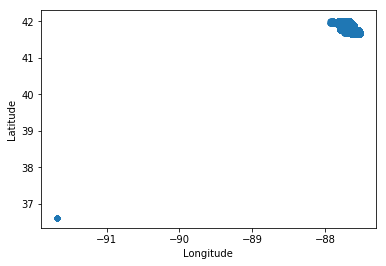

In [158]:
# Plotting 'Latitude' and 'Longitude' to find any incorrect positions
crime_df.plot.scatter(x = 'Longitude', y = 'Latitude')

In [159]:
# Checking latitudes south of 37N
crime_df[crime_df['Latitude'] < 37][:10]

,ID,Date_Converted,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
708174,757,2001-04-12 21:32:00,2001,056XX S NORMAL AV,0110,HOMICIDE,STREET,False,711,7.0,NaN,NaN,01A,0.0,0.0,36.619446,-91.686566
710545,808,2001-05-06 01:30:00,2001,020XX W 55 ST,0110,HOMICIDE,AUTO,False,915,9.0,NaN,NaN,01A,0.0,0.0,36.619446,-91.686566
713202,937,2001-07-15 00:34:00,2001,030XX S HARDING ST,0110,HOMICIDE,STREET,False,1031,10.0,NaN,NaN,01A,0.0,0.0,36.619446,-91.686566
749492,6063108,2008-01-30 22:45:00,2008,035XX S DAN RYAN LOCAL OB,0313,ROBBERY,CTA TRAIN,False,925,9.0,3.0,34.0,03,0.0,0.0,36.619446,-91.686566
759241,6125233,2008-02-15 13:48:00,2008,005XX N BESSIE COLEMAN DR,1150,DECEPTIVE PRACTICE,AIRPORT/AIRCRAFT,False,1651,16.0,41.0,76.0,11,0.0,0.0,36.619446,-91.686566
765756,6164184,2008-03-29 03:00:00,2008,006XX W NORTH AVE,0820,THEFT,STREET,False,1813,18.0,43.0,7.0,06,0.0,0.0,36.619446,-91.686566
766656,6169464,2008-03-26 04:00:00,2008,020XX W NORTH AVE,0261,CRIM SEXUAL ASSAULT,STREET,False,1434,14.0,32.0,24.0,02,0.0,0.0,36.619446,-91.686566
772752,6200282,2008-04-12 01:45:00,2008,020XX W NORTH AVE,0890,THEFT,BAR OR TAVERN,False,1434,14.0,32.0,24.0,06,0.0,0.0,36.619446,-91.686566
778440,6229358,2008-05-04 01:55:00,2008,006XX N KENNEDY EXPY OB,143A,WEAPONS VIOLATION,HIGHWAY/EXPRESSWAY,False,1323,12.0,27.0,24.0,15,0.0,0.0,36.619446,-91.686566
807285,6380603,2008-07-17 12:04:00,2008,039XX W POTOMAC AVE,0470,PUBLIC PEACE VIOLATION,STREET,False,2535,25.0,27.0,23.0,24,0.0,0.0,36.619446,-91.686566


From the above table, it appears the latitude/longitude of 36.619446/-91.686566 was given to several crime reports.  It may be the case the this position was used when the latitude/longitude was not noted.  For now, I will make these null values and revisit them later. 

In [160]:
# Making the bad latitude/longitude values null
crime_df.loc[crime_df['Latitude'] < 37, 'Latitude'] = np.nan
crime_df.loc[crime_df['Longitude'] < -91, 'Longitude'] = np.nan

In [161]:
# Checking the number of null values
len(crime_df['Latitude']) - len(crime_df['Latitude'].dropna())

60336

In [162]:
# Checking the number of null values
len(crime_df['Longitude']) - len(crime_df['Longitude'].dropna())

60336

Now there are 60336 rows missing latitude/longitude. 

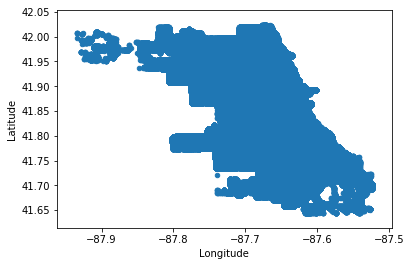

In [163]:
# Plotting 'Latitude' and 'Longitude' to check that it is ok now
crime_df.plot.scatter(x = 'Longitude', y = 'Latitude')

## X Coordinate/Y Coordinate

In [165]:
# Checking how many items are dropped from 'X Coordinate' after using .dropna()
len(crime_df['X Coordinate']) - len(crime_df['X Coordinate'].dropna())

60175

In [166]:
# Checking how many items are dropped from 'Y Coordinate' after using .dropna()
len(crime_df['Y Coordinate']) - len(crime_df['Y Coordinate'].dropna())

60175

60175 rows are missing x coordinate/y coordinate. I will leave them for now and revisit this later.

In [5]:
# Checking 'X Coordinate' with a regular expression for errors
pattern = r'^\d{7}.d{1}$' # Starts with 7 digits then a decimal and 1 digit
mask = crime_df['X Coordinate'].astype(str).str.contains(pattern)
crime_df['X Coordinate'][mask]

Series([], Name: X Coordinate, dtype: float64)

In [6]:
# Checking 'Y Coordinate' with a regular expression for errors
pattern = r'^\d{7}.d{1}$' # Starts with 7 digits then a decimal and 1 digit
mask = crime_df['Y Coordinate'].astype(str).str.contains(pattern)
crime_df['Y Coordinate'][mask]

Series([], Name: Y Coordinate, dtype: float64)

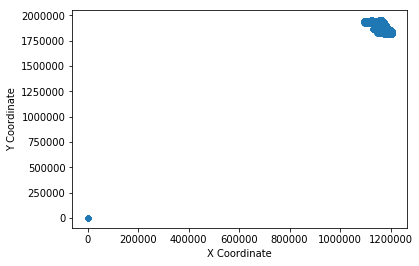

In [7]:
# Plotting 'X Coordinate' and 'Y Coordinate' to find any incorrect positions
crime_df.plot.scatter(x = 'X Coordinate', y = 'Y Coordinate')

In [8]:
# Checking X coordinates that are 0
crime_df[crime_df['X Coordinate'] < 10][:10]

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday,Closest Train Stop,Closest Train Line,Distance from Closest Train Stop (km),Closest Bus Stop,Distance from Closest Bus Stop (km),Closest Liquor Store,Distance from Closest Liquor Store (km),Distance from Chicago (km),Closest Police Station (District),Distance from Closest Police Station (km)
708174,757,2001-04-12 21:32:00,2001,056XX S NORMAL AV,HOMICIDE,STREET,False,711,7.0,NaN,NaN,0.0,0.0,NaN,NaN,4,SPRING,Q2,THURSDAY,WEEKDAY,EVENING,12,21,T2,S NORMAL AV,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
710545,808,2001-05-06 01:30:00,2001,020XX W 55 ST,HOMICIDE,AUTO,False,915,9.0,NaN,NaN,0.0,0.0,NaN,NaN,5,SPRING,Q2,SUNDAY,WEEKEND,OVERNIGHT,6,1,T1,W 55 ST,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
713202,937,2001-07-15 00:34:00,2001,030XX S HARDING ST,HOMICIDE,STREET,False,1031,10.0,NaN,NaN,0.0,0.0,NaN,NaN,7,SUMMER,Q3,SUNDAY,WEEKEND,OVERNIGHT,15,0,T2,S HARDING ST,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749492,6063108,2008-01-30 22:45:00,2008,035XX S DAN RYAN LOCAL OB,ROBBERY,CTA TRAIN,False,925,9.0,3.0,34.0,0.0,0.0,NaN,NaN,1,WINTER,Q1,WEDNESDAY,WEEKDAY,EVENING,30,22,T3,S DAN RYAN LOCAL OB,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759241,6125233,2008-02-15 13:48:00,2008,005XX N BESSIE COLEMAN DR,DECEPTIVE PRACTICE,AIRPORT/AIRCRAFT,False,1651,16.0,41.0,76.0,0.0,0.0,NaN,NaN,2,WINTER,Q1,FRIDAY,WEEKDAY,AFTERNOON,15,13,T2,N BESSIE COLEMAN DR,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765756,6164184,2008-03-29 03:00:00,2008,006XX W NORTH AVE,THEFT,STREET,False,1813,18.0,43.0,7.0,0.0,0.0,NaN,NaN,3,SPRING,Q1,SATURDAY,WEEKEND,OVERNIGHT,29,3,T3,W NORTH AVE,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766656,6169464,2008-03-26 04:00:00,2008,020XX W NORTH AVE,CRIM SEXUAL ASSAULT,STREET,False,1434,14.0,32.0,24.0,0.0,0.0,NaN,NaN,3,SPRING,Q1,WEDNESDAY,WEEKDAY,OVERNIGHT,26,4,T3,W NORTH AVE,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772752,6200282,2008-04-12 01:45:00,2008,020XX W NORTH AVE,THEFT,BAR OR TAVERN,False,1434,14.0,32.0,24.0,0.0,0.0,NaN,NaN,4,SPRING,Q2,SATURDAY,WEEKEND,OVERNIGHT,12,1,T2,W NORTH AVE,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
778440,6229358,2008-05-04 01:55:00,2008,006XX N KENNEDY EXPY OB,WEAPONS VIOLATION,HIGHWAY/EXPRESSWAY,False,1323,12.0,27.0,24.0,0.0,0.0,NaN,NaN,5,SPRING,Q2,SUNDAY,WEEKEND,OVERNIGHT,4,1,T1,N KENNEDY EXPY OB,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807285,6380603,2008-07-17 12:04:00,2008,039XX W POTOMAC AVE,PUBLIC PEACE VIOLATION,STREET,False,2535,25.0,27.0,23.0,0.0,0.0,NaN,NaN,7,SUMMER,Q3,THURSDAY,WEEKDAY,AFTERNOON,17,12,T2,W POTOMAC AVE,No Holiday,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above table, it appears that when the latitude/longitude were not known, the X/Y coordinates were 0. For now, I will make these null values and revisit them later. 

In [9]:
# Making bad X/Y coordinate values null
crime_df.loc[crime_df['X Coordinate'] < 10, 'X Coordinate'] = np.nan
crime_df.loc[crime_df['Y Coordinate'] < 10, 'Y Coordinate'] = np.nan

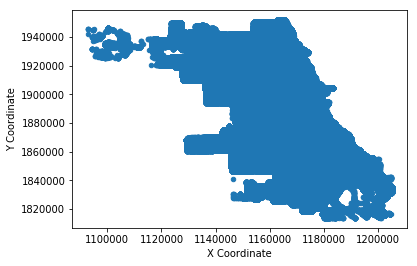

In [10]:
# Plotting 'X Coordinate' and 'Y Coordinate' to check that it is ok now
crime_df.plot.scatter(x = 'X Coordinate', y = 'Y Coordinate')

In [11]:
# Checking how many items are dropped from 'X Coordinate' after using .dropna()
len(crime_df['X Coordinate']) - len(crime_df['X Coordinate'].dropna())

60336

In [12]:
# Checking how many items are dropped from 'Y Coordinate' after using .dropna()
len(crime_df['Y Coordinate']) - len(crime_df['Y Coordinate'].dropna())

60336

There are now 60,336 rows with missing X/Y coordinates. 

## Cleaning up Columns

In [170]:
crime_df.head()

,ID,Date_Converted,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,041A,BATTERY,STREET,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,41.891399,-87.744385
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,41.773372,-87.665319
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,0486,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,41.813861,-87.596643
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,0460,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,41.800802,-87.622619
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,031A,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,41.878065,-87.743354


In [171]:
crime_df.columns

Index(['ID', 'Date_Converted', 'Year', 'Block', 'IUCR', 'Primary Type',
       'Location Description', 'Domestic', 'Beat', 'District', 'Ward',
       'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate',
       'Latitude', 'Longitude'],
      dtype='object')

In [172]:
# fixing column names
cols = ['ID', 'Date', 'Year', 'Block', 'IUCR', 'Primary Type',
       'Location Description', 'Domestic', 'Beat', 'District', 'Ward',
       'Community', 'FBI Code', 'X Coordinate', 'Y Coordinate',
       'Latitude', 'Longitude']
crime_df.columns = cols 

In [173]:
crime_df.head()

,ID,Date,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,041A,BATTERY,STREET,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,41.891399,-87.744385
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,41.773372,-87.665319
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,0486,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,41.813861,-87.596643
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,0460,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,41.800802,-87.622619
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,031A,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,41.878065,-87.743354


## Adding Columns

### Month

In [174]:
# Creating a new column with the month of the reported crime
crime_df['Month'] = list(map(lambda i: i.month, crime_df['Date']))

In [175]:
# Checking that the 'Month' column was created properly
crime_df[10000:10010]

,ID,Date,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude,Month
10000,10019974,2015-04-02 00:00:00,2015,107XX S EDBROOKE AVE,0610,BURGLARY,OTHER,False,513,5.0,9.0,49.0,05,1179147.0,1833764.0,41.699135,-87.619661,4
10001,10019975,2015-04-03 14:13:00,2015,105XX S RHODES AVE,0560,ASSAULT,STREET,False,512,5.0,9.0,49.0,08A,1181771.0,1835372.0,41.703488,-87.610003,4
10002,4771054,2005-02-01 09:00:00,2005,033XX N RIDGEWAY AVE,0840,THEFT,RESIDENCE,False,1732,17.0,30.0,21.0,06,NaN,NaN,NaN,NaN,2
10003,10019977,2015-03-25 10:00:00,2015,022XX S KEELER AVE,1130,DECEPTIVE PRACTICE,RESIDENCE,False,1013,10.0,22.0,29.0,11,1148745.0,1888710.0,41.850553,-87.729568,3
10004,10019978,2015-04-02 19:30:00,2015,055XX W HENDERSON ST,1320,CRIMINAL DAMAGE,STREET,False,1633,16.0,38.0,15.0,14,1138871.0,1921725.0,41.941335,-87.765005,4
10005,10019979,2015-03-31 15:40:00,2015,024XX S MILLARD AVE,0560,ASSAULT,STREET,False,1013,10.0,22.0,30.0,08A,1152422.0,1887647.0,41.847565,-87.716100,3
10006,10019980,2015-04-02 21:30:00,2015,015XX S KEELER AVE,1320,CRIMINAL DAMAGE,STREET,False,1012,10.0,24.0,29.0,14,1148638.0,1892091.0,41.859833,-87.729873,4
10007,10019981,2015-04-01 04:00:00,2015,012XX W 13TH ST,0486,BATTERY,VEHICLE NON-COMMERCIAL,True,1233,12.0,2.0,28.0,08B,1168336.0,1894202.0,41.865223,-87.657506,4
10008,10019982,2015-04-03 10:00:00,2015,048XX W NORTH AVE,0820,THEFT,PARKING LOT/GARAGE(NON.RESID.),False,2533,25.0,37.0,25.0,06,1143915.0,1910200.0,41.909616,-87.746756,4
10009,10019984,2015-04-03 14:59:00,2015,078XX S SAGINAW AVE,1811,NARCOTICS,SIDEWALK,False,421,4.0,7.0,43.0,18,1195280.0,1853549.0,41.753045,-87.559939,4


### Season

In [176]:
# Creating a new column with the season of the reported crime
season = {1: 'WINTER', 2: 'WINTER', 3: 'SPRING', 4: 'SPRING', 5: 'SPRING', 6: 'SUMMER', 7: 'SUMMER', 8: 'SUMMER', 9: 'FALL', 10: 'FALL', 11: 'FALL', 12: 'WINTER'}
crime_df['Season'] = list(map(lambda i: season[i], crime_df['Month']))

In [178]:
# Checking that the 'Season' column was created properly
crime_df[10000:10010]

,ID,Date,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season
10000,10019974,2015-04-02 00:00:00,2015,107XX S EDBROOKE AVE,0610,BURGLARY,OTHER,False,513,5.0,9.0,49.0,05,1179147.0,1833764.0,41.699135,-87.619661,4,SPRING
10001,10019975,2015-04-03 14:13:00,2015,105XX S RHODES AVE,0560,ASSAULT,STREET,False,512,5.0,9.0,49.0,08A,1181771.0,1835372.0,41.703488,-87.610003,4,SPRING
10002,4771054,2005-02-01 09:00:00,2005,033XX N RIDGEWAY AVE,0840,THEFT,RESIDENCE,False,1732,17.0,30.0,21.0,06,NaN,NaN,NaN,NaN,2,WINTER
10003,10019977,2015-03-25 10:00:00,2015,022XX S KEELER AVE,1130,DECEPTIVE PRACTICE,RESIDENCE,False,1013,10.0,22.0,29.0,11,1148745.0,1888710.0,41.850553,-87.729568,3,SPRING
10004,10019978,2015-04-02 19:30:00,2015,055XX W HENDERSON ST,1320,CRIMINAL DAMAGE,STREET,False,1633,16.0,38.0,15.0,14,1138871.0,1921725.0,41.941335,-87.765005,4,SPRING
10005,10019979,2015-03-31 15:40:00,2015,024XX S MILLARD AVE,0560,ASSAULT,STREET,False,1013,10.0,22.0,30.0,08A,1152422.0,1887647.0,41.847565,-87.716100,3,SPRING
10006,10019980,2015-04-02 21:30:00,2015,015XX S KEELER AVE,1320,CRIMINAL DAMAGE,STREET,False,1012,10.0,24.0,29.0,14,1148638.0,1892091.0,41.859833,-87.729873,4,SPRING
10007,10019981,2015-04-01 04:00:00,2015,012XX W 13TH ST,0486,BATTERY,VEHICLE NON-COMMERCIAL,True,1233,12.0,2.0,28.0,08B,1168336.0,1894202.0,41.865223,-87.657506,4,SPRING
10008,10019982,2015-04-03 10:00:00,2015,048XX W NORTH AVE,0820,THEFT,PARKING LOT/GARAGE(NON.RESID.),False,2533,25.0,37.0,25.0,06,1143915.0,1910200.0,41.909616,-87.746756,4,SPRING
10009,10019984,2015-04-03 14:59:00,2015,078XX S SAGINAW AVE,1811,NARCOTICS,SIDEWALK,False,421,4.0,7.0,43.0,18,1195280.0,1853549.0,41.753045,-87.559939,4,SPRING


### Quarter of Year

In [179]:
# Creating a new column with the quarter of the year of the reported crime
quarter = {1: 'Q1', 2: 'Q1', 3: 'Q1', 4: 'Q2', 5: 'Q2', 6: 'Q2', 7: 'Q3', 8: 'Q3', 9: 'Q3', 10: 'Q4', 11: 'Q4', 12: 'Q4'}
crime_df['Quarter of Year'] = list(map(lambda i: quarter[i], crime_df['Month']))

In [181]:
# Checking that the 'Season' column was created properly
crime_df[10000:10010]

,ID,Date,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year
10000,10019974,2015-04-02 00:00:00,2015,107XX S EDBROOKE AVE,0610,BURGLARY,OTHER,False,513,5.0,9.0,49.0,05,1179147.0,1833764.0,41.699135,-87.619661,4,SPRING,Q2
10001,10019975,2015-04-03 14:13:00,2015,105XX S RHODES AVE,0560,ASSAULT,STREET,False,512,5.0,9.0,49.0,08A,1181771.0,1835372.0,41.703488,-87.610003,4,SPRING,Q2
10002,4771054,2005-02-01 09:00:00,2005,033XX N RIDGEWAY AVE,0840,THEFT,RESIDENCE,False,1732,17.0,30.0,21.0,06,NaN,NaN,NaN,NaN,2,WINTER,Q1
10003,10019977,2015-03-25 10:00:00,2015,022XX S KEELER AVE,1130,DECEPTIVE PRACTICE,RESIDENCE,False,1013,10.0,22.0,29.0,11,1148745.0,1888710.0,41.850553,-87.729568,3,SPRING,Q1
10004,10019978,2015-04-02 19:30:00,2015,055XX W HENDERSON ST,1320,CRIMINAL DAMAGE,STREET,False,1633,16.0,38.0,15.0,14,1138871.0,1921725.0,41.941335,-87.765005,4,SPRING,Q2
10005,10019979,2015-03-31 15:40:00,2015,024XX S MILLARD AVE,0560,ASSAULT,STREET,False,1013,10.0,22.0,30.0,08A,1152422.0,1887647.0,41.847565,-87.716100,3,SPRING,Q1
10006,10019980,2015-04-02 21:30:00,2015,015XX S KEELER AVE,1320,CRIMINAL DAMAGE,STREET,False,1012,10.0,24.0,29.0,14,1148638.0,1892091.0,41.859833,-87.729873,4,SPRING,Q2
10007,10019981,2015-04-01 04:00:00,2015,012XX W 13TH ST,0486,BATTERY,VEHICLE NON-COMMERCIAL,True,1233,12.0,2.0,28.0,08B,1168336.0,1894202.0,41.865223,-87.657506,4,SPRING,Q2
10008,10019982,2015-04-03 10:00:00,2015,048XX W NORTH AVE,0820,THEFT,PARKING LOT/GARAGE(NON.RESID.),False,2533,25.0,37.0,25.0,06,1143915.0,1910200.0,41.909616,-87.746756,4,SPRING,Q2
10009,10019984,2015-04-03 14:59:00,2015,078XX S SAGINAW AVE,1811,NARCOTICS,SIDEWALK,False,421,4.0,7.0,43.0,18,1195280.0,1853549.0,41.753045,-87.559939,4,SPRING,Q2


### Day of the Week

In [182]:
# Creating a new column with the day of the week of the reported crime
dow = {0: 'MONDAY', 1: 'TUESDAY', 2: 'WEDNESDAY', 3: 'THURSDAY', 4: 'FRIDAY', 5: 'SATURDAY', 6: 'SUNDAY'}
crime_df['Day of the Week'] = list(map(lambda i: dow[i.weekday()], crime_df['Date']))

In [183]:
# Checking that the 'Day of the Week' column was created properly
crime_df[50000:50010]

,ID,Date,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week
50000,10094089,2015-05-31 13:00:00,2015,002XX W 116TH ST,0820,THEFT,RESIDENCE,False,522,5.0,34.0,53.0,06,1176546.0,1828016.0,41.683420,-87.629356,5,SPRING,Q2,SUNDAY
50001,10094090,2015-06-01 06:17:00,2015,006XX N SPRINGFIELD AVE,2027,NARCOTICS,APARTMENT,False,1122,11.0,27.0,23.0,18,1150274.0,1904013.0,41.892517,-87.723557,6,SUMMER,Q2,MONDAY
50002,10094096,2015-05-30 21:15:00,2015,012XX W 119TH ST,1320,CRIMINAL DAMAGE,PARKING LOT/GARAGE(NON.RESID.),False,524,5.0,34.0,53.0,14,1170310.0,1825870.0,41.677669,-87.652246,5,SPRING,Q2,SATURDAY
50003,10094098,2015-06-01 07:10:00,2015,111XX S HALSTED ST,2826,OTHER OFFENSE,STREET,False,2233,22.0,34.0,75.0,26,1172967.0,1831077.0,41.691900,-87.642368,6,SUMMER,Q2,MONDAY
50004,10094110,2015-06-01 08:00:00,2015,030XX S DR MARTIN LUTHER KING JR DR,0484,BATTERY,"SCHOOL, PUBLIC, BUILDING",False,133,1.0,2.0,35.0,08B,1179306.0,1885032.0,41.839816,-87.617516,6,SUMMER,Q2,MONDAY
50005,10094116,2015-06-01 07:48:00,2015,054XX S HALSTED ST,1811,NARCOTICS,STREET,False,934,9.0,20.0,61.0,18,1171892.0,1868942.0,41.795830,-87.645195,6,SUMMER,Q2,MONDAY
50006,10094117,2015-05-20 17:00:00,2015,054XX S HOYNE AVE,2826,OTHER OFFENSE,RESIDENCE,False,932,9.0,16.0,61.0,26,1163291.0,1868365.0,41.794431,-87.676752,5,SPRING,Q2,WEDNESDAY
50007,10094125,2015-06-01 07:05:00,2015,063XX S NORMAL BLVD,1330,CRIMINAL TRESPASS,RESIDENCE PORCH/HALLWAY,True,722,7.0,20.0,68.0,26,1174040.0,1862743.0,41.778772,-87.637502,6,SUMMER,Q2,MONDAY
50008,10094126,2015-05-08 10:00:00,2015,026XX W HADDON AVE,0810,THEFT,RESIDENTIAL YARD (FRONT/BACK),False,1211,12.0,1.0,24.0,06,1158541.0,1907540.0,41.902030,-87.693099,5,SPRING,Q2,FRIDAY
50009,10094127,2015-06-01 00:01:00,2015,041XX S PACKERS AVE,0810,THEFT,PARKING LOT/GARAGE(NON.RESID.),False,924,9.0,11.0,61.0,06,1168155.0,1877297.0,41.818838,-87.658658,6,SUMMER,Q2,MONDAY


### Day Type (weekday/weekend)

In [184]:
# Creating a new column with the type of day (weekday/weekend) of the reported crime
day_type ={'MONDAY': 'WEEKDAY', 'TUESDAY': 'WEEKDAY', 'WEDNESDAY': 'WEEKDAY', 'THURSDAY': 'WEEKDAY', 'FRIDAY': 'WEEKDAY', 'SATURDAY': 'WEEKEND', 'SUNDAY': 'WEEKEND'}
crime_df['Day Type'] = list(map(lambda i: day_type[i], crime_df['Day of the Week']))

In [185]:
# Checking that the column was created properly
crime_df.tail()

,ID,Date,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type
6726507,11483642,2015-01-01 00:01:00,2015,034XX W 60TH PL,1752,OFFENSE INVOLVING CHILDREN,RESIDENCE,True,823,8.0,16.0,66.0,20,NaN,NaN,NaN,NaN,1,WINTER,Q1,THURSDAY,WEEKDAY
6726508,11483721,2018-10-14 21:15:00,2018,056XX S UNION AVE,0486,BATTERY,RESIDENCE,False,711,7.0,20.0,68.0,08B,NaN,NaN,NaN,NaN,10,FALL,Q4,SUNDAY,WEEKEND
6726509,2332159,2002-09-05 10:21:00,2002,027XX W 14TH ST,041A,BATTERY,RESIDENCE PORCH/HALLWAY,False,1023,10.0,28.0,29.0,04B,1158111.0,1893164.0,41.862590,-87.695071,9,FALL,Q3,THURSDAY,WEEKDAY
6726510,24234,2018-10-15 01:30:00,2018,070XX S PRAIRIE AVE,0110,HOMICIDE,HOUSE,True,322,3.0,6.0,69.0,01A,1179260.0,1858331.0,41.766547,-87.618500,10,FALL,Q4,MONDAY,WEEKDAY
6726511,24235,2018-10-15 11:58:00,2018,017XX W 85TH ST,0110,HOMICIDE,ALLEY,False,614,6.0,18.0,71.0,01A,1166266.0,1848330.0,41.739390,-87.666412,10,FALL,Q4,MONDAY,WEEKDAY


### Time of Day

In [187]:
# Creating a new column with the time of day of the reported crime
day_part ={0: 'OVERNIGHT', 1: 'OVERNIGHT', 2: 'OVERNIGHT', 3: 'OVERNIGHT', 4: 'OVERNIGHT', 5: 'OVERNIGHT', 6: 'MORNING', 7: 'MORNING', 8: 'MORNING', 9: 'MORNING', 10: 'MORNING', 11: 'MORNING', 12: 'AFTERNOON', 13: 'AFTERNOON', 14: 'AFTERNOON', 15: 'AFTERNOON', 16: 'AFTERNOON', 17: 'AFTERNOON', 18: 'EVENING', 19: 'EVENING', 20: 'EVENING', 21: 'EVENING', 22: 'EVENING', 23: 'EVENING'}
crime_df['Time of Day'] = list(map(lambda i: day_part[i.hour], crime_df['Date']))

In [188]:
# Checking that the column was created properly
crime_df[50000:50010]

,ID,Date,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day
50000,10094089,2015-05-31 13:00:00,2015,002XX W 116TH ST,0820,THEFT,RESIDENCE,False,522,5.0,34.0,53.0,06,1176546.0,1828016.0,41.683420,-87.629356,5,SPRING,Q2,SUNDAY,WEEKEND,AFTERNOON
50001,10094090,2015-06-01 06:17:00,2015,006XX N SPRINGFIELD AVE,2027,NARCOTICS,APARTMENT,False,1122,11.0,27.0,23.0,18,1150274.0,1904013.0,41.892517,-87.723557,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING
50002,10094096,2015-05-30 21:15:00,2015,012XX W 119TH ST,1320,CRIMINAL DAMAGE,PARKING LOT/GARAGE(NON.RESID.),False,524,5.0,34.0,53.0,14,1170310.0,1825870.0,41.677669,-87.652246,5,SPRING,Q2,SATURDAY,WEEKEND,EVENING
50003,10094098,2015-06-01 07:10:00,2015,111XX S HALSTED ST,2826,OTHER OFFENSE,STREET,False,2233,22.0,34.0,75.0,26,1172967.0,1831077.0,41.691900,-87.642368,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING
50004,10094110,2015-06-01 08:00:00,2015,030XX S DR MARTIN LUTHER KING JR DR,0484,BATTERY,"SCHOOL, PUBLIC, BUILDING",False,133,1.0,2.0,35.0,08B,1179306.0,1885032.0,41.839816,-87.617516,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING
50005,10094116,2015-06-01 07:48:00,2015,054XX S HALSTED ST,1811,NARCOTICS,STREET,False,934,9.0,20.0,61.0,18,1171892.0,1868942.0,41.795830,-87.645195,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING
50006,10094117,2015-05-20 17:00:00,2015,054XX S HOYNE AVE,2826,OTHER OFFENSE,RESIDENCE,False,932,9.0,16.0,61.0,26,1163291.0,1868365.0,41.794431,-87.676752,5,SPRING,Q2,WEDNESDAY,WEEKDAY,AFTERNOON
50007,10094125,2015-06-01 07:05:00,2015,063XX S NORMAL BLVD,1330,CRIMINAL TRESPASS,RESIDENCE PORCH/HALLWAY,True,722,7.0,20.0,68.0,26,1174040.0,1862743.0,41.778772,-87.637502,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING
50008,10094126,2015-05-08 10:00:00,2015,026XX W HADDON AVE,0810,THEFT,RESIDENTIAL YARD (FRONT/BACK),False,1211,12.0,1.0,24.0,06,1158541.0,1907540.0,41.902030,-87.693099,5,SPRING,Q2,FRIDAY,WEEKDAY,MORNING
50009,10094127,2015-06-01 00:01:00,2015,041XX S PACKERS AVE,0810,THEFT,PARKING LOT/GARAGE(NON.RESID.),False,924,9.0,11.0,61.0,06,1168155.0,1877297.0,41.818838,-87.658658,6,SUMMER,Q2,MONDAY,WEEKDAY,OVERNIGHT


### Day

In [189]:
# Creating a new column with the day of the crime
crime_df['Day'] = list(map(lambda i: i.day, crime_df['Date']))

In [190]:
# Checking that the column was created properly
crime_df[50000:50010]

,ID,Date,Year,Block,IUCR,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day
50000,10094089,2015-05-31 13:00:00,2015,002XX W 116TH ST,0820,THEFT,RESIDENCE,False,522,5.0,34.0,53.0,06,1176546.0,1828016.0,41.683420,-87.629356,5,SPRING,Q2,SUNDAY,WEEKEND,AFTERNOON,31
50001,10094090,2015-06-01 06:17:00,2015,006XX N SPRINGFIELD AVE,2027,NARCOTICS,APARTMENT,False,1122,11.0,27.0,23.0,18,1150274.0,1904013.0,41.892517,-87.723557,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING,1
50002,10094096,2015-05-30 21:15:00,2015,012XX W 119TH ST,1320,CRIMINAL DAMAGE,PARKING LOT/GARAGE(NON.RESID.),False,524,5.0,34.0,53.0,14,1170310.0,1825870.0,41.677669,-87.652246,5,SPRING,Q2,SATURDAY,WEEKEND,EVENING,30
50003,10094098,2015-06-01 07:10:00,2015,111XX S HALSTED ST,2826,OTHER OFFENSE,STREET,False,2233,22.0,34.0,75.0,26,1172967.0,1831077.0,41.691900,-87.642368,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING,1
50004,10094110,2015-06-01 08:00:00,2015,030XX S DR MARTIN LUTHER KING JR DR,0484,BATTERY,"SCHOOL, PUBLIC, BUILDING",False,133,1.0,2.0,35.0,08B,1179306.0,1885032.0,41.839816,-87.617516,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING,1
50005,10094116,2015-06-01 07:48:00,2015,054XX S HALSTED ST,1811,NARCOTICS,STREET,False,934,9.0,20.0,61.0,18,1171892.0,1868942.0,41.795830,-87.645195,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING,1
50006,10094117,2015-05-20 17:00:00,2015,054XX S HOYNE AVE,2826,OTHER OFFENSE,RESIDENCE,False,932,9.0,16.0,61.0,26,1163291.0,1868365.0,41.794431,-87.676752,5,SPRING,Q2,WEDNESDAY,WEEKDAY,AFTERNOON,20
50007,10094125,2015-06-01 07:05:00,2015,063XX S NORMAL BLVD,1330,CRIMINAL TRESPASS,RESIDENCE PORCH/HALLWAY,True,722,7.0,20.0,68.0,26,1174040.0,1862743.0,41.778772,-87.637502,6,SUMMER,Q2,MONDAY,WEEKDAY,MORNING,1
50008,10094126,2015-05-08 10:00:00,2015,026XX W HADDON AVE,0810,THEFT,RESIDENTIAL YARD (FRONT/BACK),False,1211,12.0,1.0,24.0,06,1158541.0,1907540.0,41.902030,-87.693099,5,SPRING,Q2,FRIDAY,WEEKDAY,MORNING,8
50009,10094127,2015-06-01 00:01:00,2015,041XX S PACKERS AVE,0810,THEFT,PARKING LOT/GARAGE(NON.RESID.),False,924,9.0,11.0,61.0,06,1168155.0,1877297.0,41.818838,-87.658658,6,SUMMER,Q2,MONDAY,WEEKDAY,OVERNIGHT,1


### Third of the Month

In [193]:
# Creating a dictionary that tells which third of the month the day is
third = {}    
for i in np.arange(1, 11):
    third[i] = 'T1'
for i in np.arange(11, 21):
    third[i] = 'T2'
for i in np.arange(21, 32):
    third[i] = 'T3'

# Creating a new column with the part of month of the reported crime
crime_df['Third of Month'] = list(map(lambda i: third[i], crime_df['Day']))

### Hour

In [191]:
# Creating a new column with the hour of the crime
crime_df['Hour'] = list(map(lambda i: i.hour, crime_df['Date']))

### Street

In [198]:
# Creating a new column with the street of the crime
crime_df['Street'] = crime_df['Block'].apply(lambda block: block.split(' ', maxsplit = 1)[1])

In [197]:
crime_df['Street'][:15]

0                         W OHIO ST
1                  S MARSHFIELD AVE
2                   S LAKE PARK AVE
3                    S MICHIGAN AVE
4                        W ADAMS ST
5                     S DREXEL BLVD
6                       S MORGAN ST
7                     S PRAIRIE AVE
8                     S WOLCOTT AVE
9                     S PRAIRIE AVE
10    S DR MARTIN LUTHER KING JR DR
11                  S VINCENNES AVE
12                   S EXCHANGE AVE
13                    S ASHLAND AVE
14                    W CHICAGO AVE
Name: Street, dtype: object

In [199]:
# Checking to see that no invalid streets
pattern = r'^[A-Z \d]*$' # Street name all capitals and can have numbers
mask = crime_df['Street'].str.contains(pattern)
crime_df['Street'][~mask]

Series([], Name: Street, dtype: object)

In [201]:
# Deleting unneeded columns from crime_df
delete_columns = ['IUCR', 'FBI Code']
for col in delete_columns:
    del crime_df[col]

In [202]:
crime_df.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST


In [13]:
# Saving clean crime_df to csv
crime_df.to_csv('Crimes_2001_into_2018_Cleaned.csv', index = False)